# Problem Set 1: Analysis of racial disparities in felony sentencing

# 0. Load packages and imports

In [1]:
## basic functionality
import pandas as pd
import numpy as np
import re

## can add others if you need them
!pip install plotnine
import plotnine
from plotnine import *

import dplython as dplython
from dplython import *

import datetime
from datetime import date
from dateutil.relativedelta import *

import matplotlib
matplotlib.style.use('ggplot')

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

low_memory=False


## 0.1: Load the data (0 points)

Load the `sentencing_asof0405.csv` data

*Notes*: You may receive a warning about mixed data types upon import; feel free to ignore

In [2]:
data = pd.read_csv("pset1_inputdata/sentencing_asof0405.csv")
print(data)

/Users/prof.yeeyeeaung/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10,11,14,25) have mixed types.Specify dtype option on import or set low_memory=False.


             CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0       149765331439         175691153649  8/15/1984 12:00:00 AM   
1       149765331439         175691153649  8/15/1984 12:00:00 AM   
2       149765331439         175691153649  8/15/1984 12:00:00 AM   
3       149765331439         175691153649  8/15/1984 12:00:00 AM   
4       149765331439         175691153649  8/15/1984 12:00:00 AM   
...              ...                  ...                    ...   
248141  445516248775         905289187184   2/3/2021 12:00:00 AM   
248142  445527409730         905322500577   2/4/2021 12:00:00 AM   
248143  445587767000         905518794790   2/9/2021 12:00:00 AM   
248144  445592613204         905533705601   2/9/2021 12:00:00 AM   
248145  445593200623         905535215556   2/9/2021 12:00:00 AM   

                                 OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG  \
0                               PROMIS Conversion                False   
1                               PRO

## 0.2: Print head, dimensions, info (0 points)

In [3]:
print(data.head())
print(data.shape)
print(data.info())

        CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0  149765331439         175691153649  8/15/1984 12:00:00 AM   
1  149765331439         175691153649  8/15/1984 12:00:00 AM   
2  149765331439         175691153649  8/15/1984 12:00:00 AM   
3  149765331439         175691153649  8/15/1984 12:00:00 AM   
4  149765331439         175691153649  8/15/1984 12:00:00 AM   

    OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG    CHARGE_ID  CHARGE_VERSION_ID  \
0  PROMIS Conversion                False  50510112469       116304211997   
1  PROMIS Conversion                False  50510213021        98265074680   
2  PROMIS Conversion                False  50516447217       131972895911   
3  PROMIS Conversion                False  50516497493       131966356472   
4  PROMIS Conversion                False  50516648320        98059642859   

  DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT        DISPOSITION_DATE  \
0               FIRST DEGREE MURDER             2  12/17/2014 12:00:00 AM   
1   

# Part one: data cleaning/interpretation

## 1.1: Understanding the unit of analysis (5 points)

- Print the number of unique values for the following columns. Do so in a way that avoids copying/pasting code for 
the three:

    - Cases (`CASE_ID`)
    - People in that case (`CASE_PARTICIPANT_ID`)
    - Charges (`CHARGE_ID`)

- Write a couple sentences on the following and show an example of each (e.g., a case involving multiple people):
    
    - Why there are more unique people than unique cases?
    - Why there are more unique charges than unique people?

- Print the mean and median number of charges per case/participant 

- Print the mean and median number of participants per case

- Does the data seem to enable us to follow the same defendant across different cases they're charged in? Write 1 sentence in support of your conclusion.


In [4]:
##a
unique_values = data.agg({"CASE_ID" : "nunique",
                          "CASE_PARTICIPANT_ID" : "nunique",
                          "CHARGE_ID" : "nunique"}).reset_index()
unique_values


,index,0
0,CASE_ID,197519
1,CASE_PARTICIPANT_ID,211977
2,CHARGE_ID,229015


In [5]:
##b
#Scenario with 3 participants involved in an unique case
scenario_one = data.groupby("CASE_ID").agg({"CASE_PARTICIPANT_ID" : "nunique"}).reset_index()
scenario_one[scenario_one["CASE_PARTICIPANT_ID"] == 3]


#It is possible to have more unique people than unique cases because there might be multiple people 
#involved in a single case, which means there can be multiple uinque CASE_PARTICIPANT_IDs
#associated with a single CASE_ID. For example, in this particular case (CASE ID: 193935251654), 
#there are three CASE_PARTICIPANT_IDs which means there were 3 people involved. 

data[data["CASE_ID"] == 193935251654]


,CASE_ID,CASE_PARTICIPANT_ID
346,193935251654,3
525,207256292082,3
808,212532486732,3
885,213254130589,3
964,214169916323,3
...,...,...
191833,437496662000,3
191930,437546298879,3
192210,437728251817,3
193167,438287621262,3


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY
637,193935251654,199094236838,7/14/2005 12:00:00 AM,PROMIS Conversion,True,82198381724,221162723277,MURDER/INTENT TO KILL/INJURE,1,3/17/2014 12:00:00 AM,...,NaN,5/2/2001 12:00:00 AM,5/3/2001 12:00:00 AM,CPD DET. DIV. MISC,NaN,5/8/2005 11:15:00 AM,07/14/2005 12:00:00 AM,Charge(S) Approved,NaN,Homicide
638,193935251654,199094331210,7/14/2005 12:00:00 AM,PROMIS Conversion,True,82157457242,221161602230,MURDER/INTENT TO KILL/INJURE,1,3/17/2014 12:00:00 AM,...,NaN,5/2/2001 12:00:00 AM,5/3/2001 12:00:00 AM,CPD DET. DIV. MISC,NaN,6/7/2006 12:00:00 AM,07/14/2005 12:00:00 AM,Sf,12/29/2011 12:00:00 AM,Homicide
639,193935251654,199966991109,7/14/2005 12:00:00 AM,PROMIS Conversion,True,82115376416,221163564062,MURDER/INTENT TO KILL/INJURE,1,12/9/2011 12:00:00 AM,...,NaN,5/2/2001 12:00:00 AM,5/3/2001 12:00:00 AM,CPD DET. DIV. MISC,NaN,5/9/2005 11:30:00 AM,07/14/2005 12:00:00 AM,Charge(S) Approved,NaN,Homicide


In [11]:
#Scenario with 3 charges to an unique individual
scenario_two = data.groupby("CASE_PARTICIPANT_ID").agg({"CHARGE_ID" : "nunique"}).reset_index()
scenario_two[scenario_two["CHARGE_ID"] == 3]

#It is possible to have more unique charges than unique people because one person could 
#have multiple charges. In this particular example, one person (CASE_PARTICIPANT_ID: 125384910456) 
#is associated to three CHARGE_IDs, meaning three unique charges. 

data[data["CASE_PARTICIPANT_ID"] == 125384910456]


,CASE_PARTICIPANT_ID,CHARGE_ID
54,125384910456,3
105,134343098864,3
134,142119935848,3
141,142797245255,3
142,142797339628,3
...,...,...
210999,891913624004,3
211157,893094975427,3
211282,894170913082,3
211375,895081321868,3


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY
10595,312597938434,125384910456,9/16/1994 12:00:00 AM,Attempt Homicide,False,360780333718,671275894928,AGGRAVATED BATTERY WITH A FIREARM,2,10/29/2012 12:00:00 AM,...,Chicago,9/15/1994 12:00:00 AM,NaN,CHICAGO PD,NaN,8/7/2012 9:00:00 AM,08/09/2012 12:00:00 AM,Approved,9/18/2012 12:00:00 AM,Attempt Homicide
10596,312597938434,125384910456,9/16/1994 12:00:00 AM,Attempt Homicide,False,360780434270,671276081769,HOME INVASION,3,10/29/2012 12:00:00 AM,...,Chicago,9/15/1994 12:00:00 AM,NaN,CHICAGO PD,NaN,8/7/2012 9:00:00 AM,08/09/2012 12:00:00 AM,Approved,9/18/2012 12:00:00 AM,Attempt Homicide
10597,312597938434,125384910456,9/16/1994 12:00:00 AM,Attempt Homicide,True,360780836476,671276829133,ATTEMPT MURDER,1,10/29/2012 12:00:00 AM,...,Chicago,9/15/1994 12:00:00 AM,NaN,CHICAGO PD,NaN,8/7/2012 9:00:00 AM,08/09/2012 12:00:00 AM,Approved,9/18/2012 12:00:00 AM,Attempt Homicide


In [6]:
##c
#Mean and median number of charges per case/participant
result = data.groupby(["CASE_ID", "CASE_PARTICIPANT_ID"]).agg({"CHARGE_ID" : "nunique"}).reset_index()
print(result["CHARGE_ID"].mean())
print(result["CHARGE_ID"].median())

#Mean is 1.1261457610967227
#Median is 1.0


1.1261457610967227
1.0


In [7]:
##d
#Mean and median number of participants per case
ans = data.groupby("CASE_ID").agg({"CASE_PARTICIPANT_ID" : "nunique"}).reset_index()
print(ans["CASE_PARTICIPANT_ID"].mean())
print(ans["CASE_PARTICIPANT_ID"].median())

#Mean is 1.0731980214561636
#Median is 1.0


1.0731980214561636
1.0


In [8]:
##e
follow = data.groupby("CASE_PARTICIPANT_ID").agg({"CASE_ID" : "nunique"}).reset_index()
follow
follow["CASE_ID"].unique()

#No, the data does not enable us to follow the same defendent across different cases because after grouping by 
#defendents (CASE_PARTICIPANT_ID) and checking the number of unique cases, there was only 1 case for each 
#person. 


,CASE_PARTICIPANT_ID,CASE_ID
0,96757475659,1
1,97064562856,1
2,97249060542,1
3,97581722610,1
4,97603050731,1
...,...,...
211972,905289187184,1
211973,905322500577,1
211974,905518794790,1
211975,905533705601,1


array([1])

## 1.2.1: Which offense is final? (3 points)

- First, read the data documentation [link](https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf) and summarize in your own words the differences between `OFFENSE_CATEGORY` and `UPDATED_OFFENSE_CATEGORY` 

- Construct an indicator `is_changed_offense` that's True for case-participant-charge observations (rows) where there's a difference between the original charge (offense category) and the most current charge (updated offense category). What are some of the more common changed offenses? (can just print result of sort_values based on original offense category)

- Print one example of a changed offense from one of these categories and comment on what the reason may be


In [159]:
##a
#OFFENSE_CATEGORY is the general category of offense type before charges are made 
#and UPDATED_OFFENSE_CATEGORY is the offense type after the case progresses and charges have been made. 


In [9]:
##b
data["is_changed_offense"] = np.where(data["OFFENSE_CATEGORY"] == data["UPDATED_OFFENSE_CATEGORY"], False, True)

#If False, the offenses are the SAME. 
common_offense = data.groupby("OFFENSE_CATEGORY")["is_changed_offense"].agg("mean").sort_values(ascending=False)
print(common_offense)

#The most common changed offenses are Compelling Gang Membership, Aggravated Robbery BB Gun,
#Benefit Recipient Graud, Aggravated Battery Police Officer Firearm, and Attempt Sex Crimes. 
                            

OFFENSE_CATEGORY
Compelling Gang Membership                   1.000000
Aggravated Robbery BB Gun                    1.000000
Benefit Recipient Fraud                      1.000000
Aggravated Battery Police Officer Firearm    1.000000
Attempt Sex Crimes                           1.000000
                                               ...   
Violate Bail Bond                            0.031746
Failure to Register as a Sex Offender        0.014797
Narcotics                                    0.009410
Escape - Failure to Return                   0.009064
Prostitution                                 0.004458
Name: is_changed_offense, Length: 88, dtype: float64


In [20]:
##c
changed_cases = data.loc[data["is_changed_offense"] == True]
print(changed_cases.iloc[13416])

#In this particular case, the charge was updated from Aggravated Robbery to Armed Robbery. 
#Armed Robbery, the use of a weapon, is a less serious charge than Aggravated Robbery, where a 
#deadly weapon is involved.It could be that after further investigation, the court found
#the weapon used not deadly or intended to cause fatal injuries.  


CASE_ID                                                    392187590096
CASE_PARTICIPANT_ID                                        737865322935
RECEIVED_DATE                                      5/8/2012 12:00:00 AM
OFFENSE_CATEGORY                                     Aggravated Robbery
PRIMARY_CHARGE_FLAG                                               False
CHARGE_ID                                                  356870386535
CHARGE_VERSION_ID                                          663918558373
DISPOSITION_CHARGED_OFFENSE_TITLE     AGGRAVATED UNLAWFUL USE OF WEAPON
CHARGE_COUNT                                                          3
DISPOSITION_DATE                                  5/26/2015 12:00:00 AM
DISPOSITION_CHARGED_CHAPTER                                         720
DISPOSITION_CHARGED_ACT                                               5
DISPOSITION_CHARGED_SECTION                                24-1.6(a)(1)
DISPOSITION_CHARGED_CLASS                                       

## 1.2.2: Simplifying the charges (5 points)

Using the field (`UPDATED_OFFENSE_CATEGORY`), create a new field, `simplified_offense_derived`, that simplifies the many offense categories into broader buckets using the following process:

First, combine all offenses beginning with "Aggravated" into a single category without that prefix (e.g., Aggravated Battery and Battery just becomes Battery)

Then:
- Combine all offenses with arson into a single arson category (`Arson`)
- Combine all offenses with homicide into a single homicide category (`Homicide`)
- Combine all offenses with vehicle/vehicular in the name into a single vehicle category (`Vehicle-related`)
- Combine all offenses with battery in the name into a single battery category (`Battery`)

Try to do so efficiently (e.g., using map and a dictionary or np.select rather than separate line for each recoded offense)

Print the difference between the # of unique offenses in the original `UPDATED_OFFENSE_CATEGORY` field and the # of unique offenses in your new `simplified_offense_derived` field


In [10]:
data["simplified_offense_derived"]= data["UPDATED_OFFENSE_CATEGORY"].str.replace("Aggravated ", "", case = False)
data.loc[data.simplified_offense_derived.str.contains("Arson"), "simplified_offense_derived" ] = "Arson"
data.loc[data.simplified_offense_derived.str.contains("Homicide"), "simplified_offense_derived" ] = "Homicide"
data.loc[data.simplified_offense_derived.str.contains("Vehicular|Vehicle"), "simplified_offense_derived" ] = "Vehicle-related"
data.loc[data.simplified_offense_derived.str.contains("Battery"), "simplified_offense_derived" ] = "Battery"

diff = data["UPDATED_OFFENSE_CATEGORY"].nunique() - data["simplified_offense_derived"].nunique()
print(diff)

#There are 14 more unique offenses in the original UPDATED_OFFENSE_CATEGORY than in the new
#simplified_offense_derived field. 


14


## 1.3: Cleaning additional variables (10 points)

Clean the following variables; make sure to retain the original variable in data and use the derived suffix so it's easier to pull these cleaned out variables later (e.g., `age_derived`) to indicate this was a transformation

- Race: create True/false indicators for `is_black_derived` (Black only or mixed race with hispanic), Non-Black Hispanic, so either hispanic alone or white hispanic (`is_hisp_derived`), White non-hispanic (`is_white_derived`), or none of the above (`is_othereth_derived`)

- Gender: create a boolean true/false indicator for `is_male_derived` (false is female, unknown, or other)

- Age at incident: you notice outliers like 130-year olds. Winsorsize the top 0.01% of values to be equal to the 99.99th percentile value pre-winsorization. Call this `age_derived`

- Create `sentenceymd_derived` that's a version of `SENTENCING_DATE` converted to datetime format. Also create a rounded version, `sentenceym_derived`, that's rounded down to the first of the month and the year (e.g., 01-05-2016 and 01-27-2016 each become 01-01-2016)
    - Hint: all timestamps are midnight so u can strip in conversion. For full credit, before converting, you notice that some of the years have been mistranscribed (e.g., 291X or 221X instead of 201X). Programatically fix those (eg 2914 -> 2014). Even after cleaning, there will still be some that are after the year 2021 that we'll filter out later. For partial credit, you can ignore the timestamps that cause errors and set errors = "coerce" within `pd.to_datetime()` to allow the conversion to proceed. 

- Sentencing judge: create an identifier (`judgeid_derived`) for each unique judge (`SENTENCE_JUDGE`) structured as judge_1, judge_2...., with the order determined by sorting the judges (will sort on fname then last). When finding unique judges, there are various duplicates we could weed out --- for now, just focus on (1) the different iterations of Doug/Douglas Simpson, (2) the different iterations of Shelley Sutker (who appears both with her maiden name and her hyphenated married name). 
     - Hint: due to mixed types, you may need to cast the `SENTENCE_JUDGE` var to a diff type to sort

After finishing, print a random sample of 10 rows (data.sample(n = 10)) with the original and cleaned columns for the relevant variables to validate your work

In [11]:
##a
data["is_black_derived"] = np.where(data.RACE.str.contains("Black", case=False, na=False), True, False)
data["is_hisp_derived"] = np.where(data.RACE.str.contains("Hispanic", case=False, na=False), True, False)
data["is_white_derived"] = np.where(data.RACE.str.contains("White", case=False, na=False), True, False)
data["is_othereth_derived"] = np.where((data["is_black_derived"] == False) &
                                       (data["is_hisp_derived"] == False) & 
                                       (data["is_white_derived"] == False), True, False)


In [12]:
##b
data["is_male_derived"] = np.where(data["GENDER"].
                                str.contains("Female|Unknown|Other", case=False, na=False), False, True)


In [13]:
##c
value_99p = data["AGE_AT_INCIDENT"].quantile(0.9999)
data["age_derived"] = np.where((data["AGE_AT_INCIDENT"] > value_99p), value_99p, data["AGE_AT_INCIDENT"]) 
data["age_derived"].sort_values(ascending=False)

244154    81.0
40911     81.0
81589     81.0
32283     81.0
127883    81.0
          ... 
248098     NaN
248100     NaN
248130     NaN
248139     NaN
248140     NaN
Name: age_derived, Length: 248146, dtype: float64

In [14]:
##d
#Replace erroneous dates
data["SENTENCE_DATE"] = [re.sub(r'2[1-9]([0-9]+)', r"20\1", str(date)) 
                             if bool(re.search('\/2[1-9][0-9]+', str(date))) else 
                            str(date) 
                            for date in 
                            data.SENTENCE_DATE]

#Cast as datetime
data["sentenceymd_derived"] = data["SENTENCE_DATE"].apply(pd.to_datetime)
data["sentenceym_derived"] = data["sentenceymd_derived"] + pd.offsets.Day() - pd.offsets.MonthBegin()

<>:4: DeprecationWarning: invalid escape sequence \/


In [15]:
##e
data["judge_sort"] = data["SENTENCE_JUDGE"].astype(str)

#Weed out duplicates 
data.loc[data.judge_sort.str.contains("Simpson"), "judge_sort" ] = "Doug Simpson"
data.loc[data.judge_sort.str.contains("Shelley"), "judge_sort" ] = "Shelley Sutker"

#Number them and add "judge_"
data["judgeid_derived"] = data.groupby("judge_sort").ngroup()
data["judgeid_derived"] = "judge_" + data["judgeid_derived"].astype(str)
data = data.drop(columns=["judge_sort"])


In [26]:
##f
data.sample(n=10)

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY,is_changed_offense,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived
121995,404738818334,775474067333,2/6/2014 12:00:00 AM,Forgery,True,377769775686,703249456800,THEFT,1,3/6/2014 12:00:00 AM,...,2/6/2014 5:20:00 PM,02/06/2014 12:00:00 AM,Approved,3/6/2014 12:00:00 AM,Theft,True,23.0,2014-03-06,2014-03-01,judge_152
13106,378799437083,699229053829,6/22/2010 12:00:00 AM,Forgery,False,336294873941,625097923070,FORGERY,8,11/17/2011 12:00:00 AM,...,6/21/2010 4:40:00 PM,06/22/2010 12:00:00 AM,Approved,8/6/2010 12:00:00 AM,Theft,True,37.0,2011-12-14,2011-12-01,judge_83
59797,390661770055,733678027629,2/22/2012 12:00:00 AM,Robbery,True,354386360942,659235105215,AGGRAVATED ROBBERY,1,5/24/2012 12:00:00 AM,...,2/22/2012 3:31:00 AM,02/22/2012 12:00:00 AM,Approved,3/19/2012 12:00:00 AM,Aggravated Robbery,True,20.0,2012-05-24,2012-05-01,judge_334
216873,428283587307,850218656945,12/15/2017 12:00:00 AM,Aggravated Battery Police Officer,True,419776142669,784585510731,ATTEMPT AGGRAVATED BATTERY,1,1/11/2018 12:00:00 AM,...,NaN,12/15/2017 12:00:00 AM,Approved,12/29/2017 12:00:00 AM,Aggravated Battery Police Officer,False,29.0,2018-01-11,2018-01-01,judge_235
35291,385313763471,718323667784,5/21/2011 12:00:00 AM,Aggravated DUI,True,345337927687,642189682442,AGGRAVATED DRIVING UNDER THE INFLUENCE OF ALCOHOL,1,2/21/2012 12:00:00 AM,...,5/21/2011 10:40:00 PM,05/21/2011 12:00:00 AM,Approved,7/18/2011 12:00:00 AM,Aggravated DUI,False,41.0,2012-02-21,2012-02-01,judge_146
10621,323806180699,132471225922,10/23/1995 12:00:00 AM,PROMIS Conversion,False,153488729752,272365693878,MURDER/STRONG PROB KILL/INJURE,2,7/6/2012 12:00:00 AM,...,10/23/1995 9:00:00 AM,10/23/1995 12:00:00 AM,Charge(S) Approved,11/29/1995 12:00:00 AM,Homicide,True,22.0,2012-07-06,2012-07-01,judge_113
117124,403581750375,771850268540,11/29/2013 12:00:00 AM,Armed Robbery,False,375805199421,699543276166,ATTEMPT ARMED ROBBERY,2,11/13/2014 12:00:00 AM,...,11/28/2013 12:55:00 PM,11/29/2013 12:00:00 AM,Approved,1/6/2014 12:00:00 AM,Armed Robbery,False,22.0,2014-11-13,2014-11-01,judge_35
90915,397624737466,753516577777,2/7/2013 12:00:00 AM,Aggravated DUI,False,368228237610,685293930888,"FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT,...",4,10/4/2013 12:00:00 AM,...,2/1/2013 10:13:00 PM,02/02/2013 12:00:00 AM,Approved,5/7/2013 12:00:00 AM,Aggravated DUI,False,38.0,2013-10-04,2013-10-01,judge_162
79178,395020269861,745924993456,9/25/2012 12:00:00 AM,Narcotics,True,361920739170,673410087723,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,1,11/20/2014 12:00:00 AM,...,9/21/2012 9:50:00 AM,NaN,NaN,10/23/2012 12:00:00 AM,Narcotics,False,24.0,2012-12-20,2012-12-01,judge_36
147466,410742384174,794264330885,12/28/2014 12:00:00 AM,Retail Theft,True,387654848146,723864572761,RET THEFT/UNDER-RING/<$300,1,1/26/2015 12:00:00 AM,...,12/27/2014 3:32:00 PM,12/28/2014 12:00:00 AM,Approved,NaN,Retail Theft,False,29.0,2015-01-26,2015-01-01,judge_237


## 1.4: Subsetting rows to analytic dataset (5 points)

You decide based on the above to simplify things in the following ways:
    
- Subset to cases where only one participant is charged, since cases with >1 participant might have complications like 
plea bargains/informing from other participants affecting the sentencing of the focal participant

- To go from a participant-case level dataset, where each participant is repeated across charges tied to the case, to a participant-level dataset, where each participant has one charge, subset to a participant's primary charge and their current sentence (`PRIMARY_CHARGE_FLAG` is True and `CURRENT_SENTENCE_FLAG` is True). Double check that this worked by confirming there are no longer multiple charges for the same case-participant

- Filter out observations where judge is nan or nonsensical (indicated by is.null or equal to FLOOD)

- Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)

After completing these steps, print the number of rows in the data

In [16]:
##a
#Find cases where only one participant is charged 
groupby_case = data.groupby("CASE_ID").agg({"CASE_PARTICIPANT_ID": "nunique"}).reset_index()
cases_one_p = groupby_case[groupby_case["CASE_PARTICIPANT_ID"] == 1]

one_case_p_copy = data.copy()

#Subset to cases with only one participant charged
one_case_p_copy = (one_case_p_copy[one_case_p_copy.CASE_ID.isin(cases_one_p.CASE_ID)])


In [17]:
##b
#Subset to cases where both conditions are True 
one_case_p_copy = one_case_p_copy.loc[(one_case_p_copy.PRIMARY_CHARGE_FLAG == True) & (one_case_p_copy.CURRENT_SENTENCE_FLAG == True)]

#Check if there are multiple charges for same case-participant
check = one_case_p_copy.groupby("CASE_ID").agg({"CASE_PARTICIPANT_ID": "nunique",
                                    "CHARGE_ID" : "nunique"}).reset_index()
check["CHARGE_ID"].unique()

array([1])

In [18]:
##c
#Filter out observations where judge is nan or nonsensical 
one_case_p_copy = one_case_p_copy[one_case_p_copy["SENTENCE_JUDGE"].notnull()]


In [19]:
##d
#Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)
check_dates = one_case_p_copy[one_case_p_copy["sentenceymd_derived"].isin(pd.date_range("2012-01-01", "2021-04-05"))]


In [20]:
##e
check_dates.shape[0]

#There are 135165 rows in the data frame after completing the steps. 

135165

# Part two: investigating Black vs. White sentencing disparities

Now that the data are cleaned, we're going to investigate different types of disparities in sentencing between Black defendants and White defendants. We're focusing on these groups for the purpose of the problem set, but the analysis could be extended to study Hispanic defendants or, in a different jurisdiction, Asian and other minoritized groups.

**Details if interested in digging deeper**: If interested (optional), you can read more technical coverage of how we might (1) measure disparities, and (2) what factors you want to adjust for when deciding whether two defendants are 'similarly situated' but for their race in the following sources:

- [Review of sentencing disparities research](https://www.journals.uchicago.edu/doi/full/10.1086/701505)
- [Discussion of causal model/blinding race at charging stage of the prosecutorial process](https://5harad.com/papers/blind-charging.pdf)
- [Discussion of measuring discrimination in policing that can generalize to the sentencing case](https://www.annualreviews.org/doi/abs/10.1146/annurev-criminol-011518-024731)
- [General discussion of causal challenges in measuring between-group disparities](https://osf.io/preprints/socarxiv/gx4y3/)

**One major caveat**: when investigating whether two similar defendants received different sentences, we're missing one important attribute that influences sentencing: the defendant's criminal history. This influences sentencing both through sentencing guidelines, which can prescribe longer sentences for those who have certain types of prior convictions, and through judicial discretion if judges are more lenient with first-time defendants. The above sources discuss how much we want to "control away" for this prior history, since if we think there are racial biases in which defendants, conditional on *committing* a crime, are arrested and charged, we may not want to adjust for that factor. More discussion [in this article](https://www.themarshallproject.org/2019/12/03/the-growing-racial-disparity-in-prison-time)


## 2.0: (0 points)

First, read in the following dataset (regardless of progress on part one): `sentencing_cleaned.pkl` (if you can't read in the pkl you can read in the .csv format but may need to recast some of the datetime columns)

*Note*: don't worry if there are slight differences in your output from Part One and this dataset/it's not a good use of time to try to reverse engineer Part One answers from this cleaned data.

In [21]:
bwdata = pd.read_pickle("pset1_inputdata/sentencing_cleaned.pkl")
print(bwdata)

             CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
9       149765331439         175691153649  8/15/1984 12:00:00 AM   
16      150065796098         162105612284  8/23/1984 12:00:00 AM   
18      154954734978         225758446387   6/8/2001 12:00:00 AM   
19      155222744754         217349881776  1/31/2001 12:00:00 AM   
26      155327892699         217212381455   2/6/2001 12:00:00 AM   
...              ...                  ...                    ...   
248141  445516248775         905289187184   2/3/2021 12:00:00 AM   
248142  445527409730         905322500577   2/4/2021 12:00:00 AM   
248143  445587767000         905518794790   2/9/2021 12:00:00 AM   
248144  445592613204         905533705601   2/9/2021 12:00:00 AM   
248145  445593200623         905535215556   2/9/2021 12:00:00 AM   

                                 OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG  \
9                               PROMIS Conversion                 True   
16                              PRO

In [39]:
bwdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135165 entries, 9 to 248145
Data columns (total 52 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   CASE_ID                            135165 non-null  int64         
 1   CASE_PARTICIPANT_ID                135165 non-null  int64         
 2   RECEIVED_DATE                      135165 non-null  object        
 3   OFFENSE_CATEGORY                   135165 non-null  object        
 4   PRIMARY_CHARGE_FLAG                135165 non-null  bool          
 5   CHARGE_ID                          135165 non-null  int64         
 6   CHARGE_VERSION_ID                  135165 non-null  int64         
 7   DISPOSITION_CHARGED_OFFENSE_TITLE  135165 non-null  object        
 8   CHARGE_COUNT                       135165 non-null  int64         
 9   DISPOSITION_DATE                   135165 non-null  object        
 10  DISPOSITION_CHARGED_

## 2.1: Investigating one type of between-group difference: who reaches the sentencing stage? (5 points)

Tabulate and visualize the proportion of defendants, out of all defendants sentenced in a given month/year, who are Black and who are White (separate proportions)

- Denominator is number of unique cases that month
- Numerator for black defendants is count of is_black_derived
- Numerator for white defendants is count of is_white_derived
- Fraction of each is numerator/denominator

- Print the table
- Create a graph with two lines--- one for Black defendants as fraction of total; another for White defendants. Make sure it includes a legend summarizing which color is for which group, and clean the legend so that it has informative names (e.g., Black or White rather than prop_black or prop_white)
- Use mathematical notation to write out each of the proportions using summation notation in a 1-2 sentence writeup describing trends. What seems to be going on in April and May 2020? 

**Optional challenge**: improve the viz by shading the background of the visualization for months with fewer than 100 cases 

**Optional challenge**: improve the viz by adding a vertical line for 12-01-2016, the month that new State's Attorney Foxx took office 

,sentenceym_derived,CASE_ID,is_black_derived,is_white_derived,prop_black,prop_white
0,2012-01-01,1674,1134,242,0.677419,0.144564
1,2012-02-01,1450,941,233,0.648966,0.160690
2,2012-03-01,1612,1030,255,0.638958,0.158189
3,2012-04-01,1436,1000,211,0.696379,0.146936
4,2012-05-01,1545,1074,223,0.695146,0.144337
...,...,...,...,...,...,...
106,2020-11-01,491,298,76,0.606925,0.154786
107,2020-12-01,537,347,85,0.646182,0.158287
108,2021-01-01,447,278,50,0.621924,0.111857
109,2021-02-01,491,320,66,0.651731,0.134420


/Users/prof.yeeyeeaung/opt/anaconda3/lib/python3.9/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


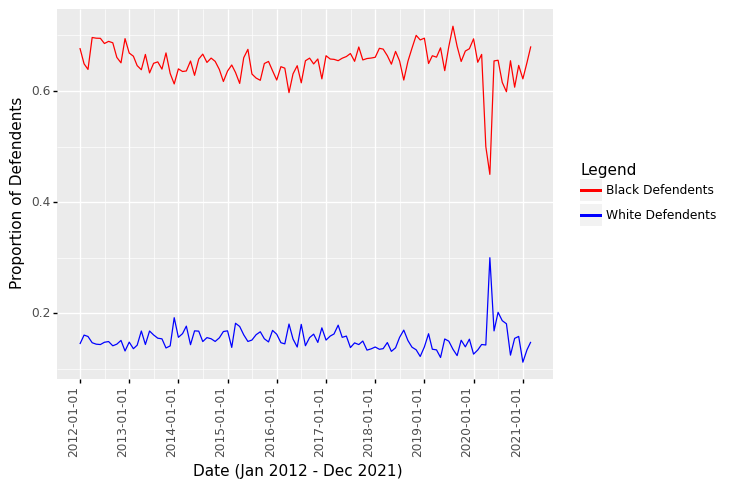

In [22]:
##a
defendents = bwdata.groupby("sentenceym_derived").agg({"CASE_ID" : "nunique",
                                                 "is_black_derived": "sum" , 
                                                 "is_white_derived" : "sum"}).reset_index()
#Find proportion of defendents for both races
defendents["prop_black"] = defendents["is_black_derived"]/defendents["CASE_ID"]
defendents["prop_white"] = defendents["is_white_derived"]/defendents["CASE_ID"]
defendents

#Tabulate data
defen_t = defendents.reset_index()
defen_t = pd.melt(defen_t, id_vars="sentenceym_derived", value_vars=["prop_black", "prop_white"])

#date = datetime.date(2016, 12, 1)

plot = ggplot(defen_t, aes(x="sentenceym_derived", y="value", color="variable")) + geom_line() + scale_color_manual(name="Legend", labels= ["Black Defendents", "White Defendents"], values = ["red", "blue"])

plot = plot + xlab("Date (Jan 2012 - Dec 2021)") + ylab("Proportion of Defendents") + theme(axis_text_x = element_text(angle = 90, hjust=1))
#geom_vline(xintercept= date) + geom_text(label="2016-12-01: New State Attorney Foxx takes office", x=date, y=0.4, angle=90)

print(plot)


Proportion of Black Defendents $\frac{\sum_\ Black\ Defendents}{\sum_\ Defendents}$

Proportion of White Defendents $\frac{\sum_\ White\ Defendents}{\sum_\ Defendents}$

The proportion of white defendents is significantly lower than the proportion of black defendents and the range of the 
proportion of black defendents is approximatly between 0.6 and 0.7 while the range of the proportion of white defendents is approximately between 0.1 and 0.2 from 2012 to 2021. The rates remain between the respective ranges except for a drastic change in April and May 2020 where the proportion of black defendents decreased down to around 0.46 and the proportion of white defendents increased up to 0.3. 


## 2.2: Investigating the first type of disparity: probation versus incaceration (10 points)

One type of disparity beyond who arrives at the sentencing stage is whether the defendant receives probation or incaceration.

According to the codebook, incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections"

Recreate the previous plot but where the y axis represents the difference between the following proportions (can be either Black - White or White - Black but make sure to label), adding a smoothed line:

- Percent of black defendants who are incarcerated out of all black defendants that month/year 
- Percent of white defendants who are incarcerated out of all white defendants that month/year 

In a markdown cell after, write 1-2 sentences on your observations of trends over time. Do gaps seem to be widening or increasing?

,sentenceym_derived,allBlack,allWhite,incarBlack,incarWhite,incar_prop_Black,incar_prop_White,difference
0,2012-01-01,1134,242,674,87,0.594356,0.359504,0.234852
1,2012-02-01,941,233,566,87,0.601488,0.373391,0.228097
2,2012-03-01,1030,255,602,113,0.584466,0.443137,0.141329
3,2012-04-01,1000,211,598,94,0.598000,0.445498,0.152502
4,2012-05-01,1074,223,579,73,0.539106,0.327354,0.211752
...,...,...,...,...,...,...,...,...
106,2020-11-01,298,76,122,23,0.409396,0.302632,0.106764
107,2020-12-01,347,85,170,32,0.489914,0.376471,0.113443
108,2021-01-01,278,50,138,22,0.496403,0.440000,0.056403
109,2021-02-01,320,66,136,13,0.425000,0.196970,0.228030


/Users/prof.yeeyeeaung/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


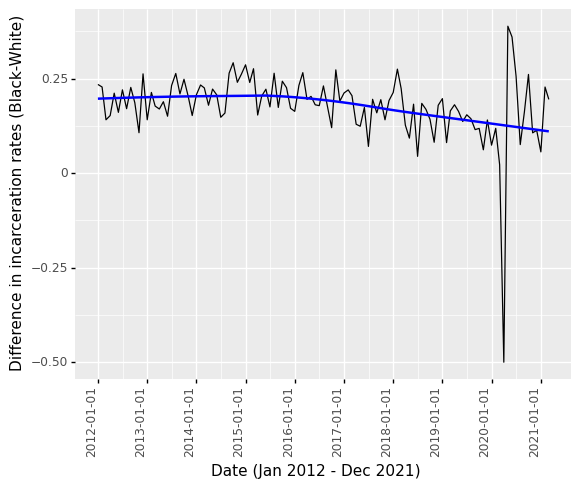

In [23]:
#Group by incarceration and find defendents by race 
incarceration = bwdata[bwdata.COMMITMENT_TYPE == "Illinois Department of Corrections"].groupby("sentenceym_derived").agg({"CASE_ID" : "nunique", 
                                                                                                            "is_black_derived": "sum", 
                                                                                                            "is_white_derived" : "sum"}).reset_index()
#Rename columns for clarity
defendents = defendents.rename(columns={"is_black_derived" : "allBlack", "is_white_derived" : "allWhite"})
incarceration = incarceration.rename(columns={"is_black_derived" : "incarBlack", "is_white_derived" : "incarWhite"})

#Make new dataframe
ndata = [defendents["sentenceym_derived"], defendents["allBlack"], defendents["allWhite"], incarceration["incarBlack"], incarceration["incarWhite"]]
headers = ["sentenceym_derived", "allBlack", "allWhite", "incarBlack", "incarWhite"]
new_incarcerated_dat = pd.concat(ndata, axis=1, keys=headers)

#Find proportion of incarcerated black and white defendents 
new_incarcerated_dat["incar_prop_Black"] = new_incarcerated_dat["incarBlack"] / new_incarcerated_dat["allBlack"]
new_incarcerated_dat["incar_prop_White"] = new_incarcerated_dat["incarWhite"] / new_incarcerated_dat["allWhite"]
#Find difference in the proportions
new_incarcerated_dat["difference"] = new_incarcerated_dat["incar_prop_Black"] - new_incarcerated_dat["incar_prop_White"]

new_incarcerated_dat

plot2 = ggplot(new_incarcerated_dat, aes(x="sentenceym_derived", y="difference")) + geom_line(color="black") + xlab("Date (Jan 2012 - Dec 2021)") + ylab("Difference in incarceration rates (Black-White)") + geom_smooth(color="blue")
plot2 = plot2 + theme(axis_text_x = element_text(angle = 90, hjust=1)) #+ scale_color_manual(name="Legend", labels= ("Black - White"), values = ("black"))

print(plot2)


In [ ]:
#Based on the graph, the gap seems to be decreasing, although there are a lot of fluctuations. 
#An interesting thing to note also is that in mid 2020, 
#the gap reversed to where there were more White defendents who were incarcerated than Black defendents.
#However, the gap presented itself again, back to its previous pattern, shortly after this period. 

## 2.3: Investigating mechanisms: incaceration rates by charge

Your colleague sees the previous graph and is worried that the gap could be different---either wider or smaller---if you adjust for the fact that prosecutors have discretion in what crimes to charge defendants with. If white defendants are charged with crimes that tend to receive probation rather than incarceration, that could explain some of the gaps.

In the next questions, you'll begin to investigate this.

### 2.3.1: Find the most common offenses (3 points)

First, create a set of 'frequent offenses' that represent (over the entire period) the union of the 10 offenses Black defendant are most likely to be charged with and the 10 offenses white defendants are most likely to be charged with (might be far less than 20 total if there's a lot of overlap in common charges)

Use the `simplified_offense_derived` for this

In [24]:
#Find 10 offenses defenents from both races are most likely to be charged with
black_offenses = bwdata[bwdata.is_black_derived == True]["simplified_offense_derived"].value_counts()[:10]
white_offenses = bwdata[bwdata.is_white_derived == True]["simplified_offense_derived"].value_counts()[:10]

#Create new set "frequent_offenses"
frequent_offenses = set(black_offenses.index)
frequent_offenses.update(white_offenses.index) 

frequent_offenses


{'Battery',
 'Burglary',
 'DUI',
 'Driving With Suspended Or Revoked License',
 'Narcotics',
 'Other Offense',
 'Residential Burglary',
 'Retail Theft',
 'Robbery',
 'Theft',
 'UUW - Unlawful Use of Weapon',
 'Vehicle-related'}

### 2.3.2: Look at incarceration rates (again just whether incarcerated) by race and offense type for these top offenses (3 points)

Print a wide-format version of the resulting table (so each row is an offense type, one col is black incarceration rate for that offense type; another is the white incarceration rate) and interpret. Which offenses show the largest disparities in judges being less likely to sentence White defendants to incarceration/more likely to offer those defendants probation?


In [25]:
#Subset to cases with offesnes in frequent offenses set
incar_race_offenses = (bwdata[bwdata.simplified_offense_derived.isin(frequent_offenses)])

#Find black and white defendents incarcerated 
incar_race_offenses["black_incar"] = np.where((incar_race_offenses.is_black_derived == True) &
                                              (incar_race_offenses.COMMITMENT_TYPE == "Illinois Department of Corrections"),
                                             True, False)

incar_race_offenses["white_incar"] = np.where((incar_race_offenses.is_white_derived == True) &
                                              (incar_race_offenses.COMMITMENT_TYPE == "Illinois Department of Corrections"),
                                             True, False)

#Find incarcarceration rates by race and offense type 
compare_rates = incar_race_offenses.groupby("simplified_offense_derived").agg({"CASE_ID" : "nunique",
                                                                       "is_black_derived": "sum" ,
                                                                       "is_white_derived" : "sum",
                                                                      "black_incar" : "sum",
                                                                      "white_incar" : "sum"}).reset_index()

compare_rates["black_incar_rate"] = compare_rates["black_incar"] / compare_rates["is_black_derived"]
compare_rates["white_incar_rate"] = compare_rates["white_incar"] / compare_rates["is_white_derived"]
compare_rates2 = compare_rates.drop(["CASE_ID", "is_black_derived", "is_white_derived", "black_incar", "white_incar"], axis=1)

#Find difference in incarceration rate between the two races 
compare_rates2["diff"] = compare_rates2["black_incar_rate"] - compare_rates2["white_incar_rate"]

compare_rates2


/var/folders/58/f_63qv_53qq73vs28kd4kdyr0000gn/T/ipykernel_20167/1050870403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,simplified_offense_derived,black_incar_rate,white_incar_rate,diff
0,Battery,0.509032,0.275552,0.233480
1,Burglary,0.661927,0.535763,0.126164
2,DUI,0.404997,0.341855,0.063143
3,Driving With Suspended Or Revoked License,0.582193,0.496552,0.085642
4,Narcotics,0.537876,0.242535,0.295341
5,Other Offense,0.340580,0.230228,0.110351
6,Residential Burglary,0.717791,0.654114,0.063677
7,Retail Theft,0.595713,0.449582,0.146132
8,Robbery,0.650341,0.589286,0.061055
9,Theft,0.386961,0.318721,0.068240


In [83]:
#White defendents charged with Narcotics are most likely to be offered probation compared to black defendents.
#Other offenses categories where black defendends are more likely to be incarcerated are, in decreasing order,
#Battery, UUW - Unlawful Use of Weapon, and Retail Theft. 

### 2.3.3: Examine whether this changes pre and post change to charging threshold for retail theft (13 points)

One important question is not only whether there are disparities by offense type but also whether these disparities are changing over time.

The SAO, for instance, announced in December of 2016 that they would no longer default to charging retail thefts of under \$1,000 as felonies. This change might have (1) decreased disparities or (2) increased disparities, depending on the correlation between race/ethnicity and magnitude of goods stolen: [news coverage](https://www.dnainfo.com/chicago/20161215/little-village/kim-foxx-raises-bar-for-retail-theft-felonies/). 

Focusing on `simplified_offense_derived` == "Retail theft." Using a function and/or loop (Dec. 2016 is always excluded as a transition month):

- Compare Black-White disparities before and after the change using a two-month bandwidth (so pre is October and November 2016; post is January and February 2017)

- Compare Black-White disparities before and after the change using a four-month bandwidth (so pre is August- November 2016; post is January - April 2017)

- Compare Black-White disparities using an eight-month bandwidth

- Compare Black-White disparities using a twelve-month bandwidth


------------------ 

- Print a table with the results (any organization is fine as long as it's clear)  

- Create a bar chart where the x axis represents different bandwidths (2, 4, etc); the y axis the size of the Black-White gap in whether the defendant receives incarceration, and for each of the x axis points, you have one shaded bar representing "before" the change, another representing "after" the change (make sure that before is ordered before after and the bandwidths are from smallest to largest)

*Note*: for each of the bandwidths include dates the entire month (e.g., for the first, include not only 02-01-2017 but everything up through 02-28-2017; easiest way is for the subsetting to use the rounded `sentenceym_derived`). Also make sure to only include white or black defendants.


**Extra credit**: because the bandwidths have different sample sizes, a better viz incorporates measures of uncertainty. Add standard errors to the estimates using the formula: $(\dfrac{p(1-p)}{n})^{0.5}$ where $p$ is the gap and $N$ is the number of cases in each bandwidth period 


,is_after,black_rate,white_rate,difference,months_bw
0,afterdec2016,0.372340,0.217391,0.154949,2-months
1,beforedec2016,0.626374,0.538462,0.087912,2-months
0,afterdec2016,0.411972,0.330357,0.081615,4-months
1,beforedec2016,0.558511,0.476923,0.081588,4-months
0,afterdec2016,0.493450,0.450000,0.043450,8-months
1,beforedec2016,0.568990,0.436090,0.132900,8-months
0,afterdec2016,0.510714,0.446009,0.064705,12-months
1,beforedec2016,0.580889,0.419271,0.161618,12-months


/Users/prof.yeeyeeaung/opt/anaconda3/lib/python3.9/site-packages/plotnine/guides/guide_legend.py:308: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


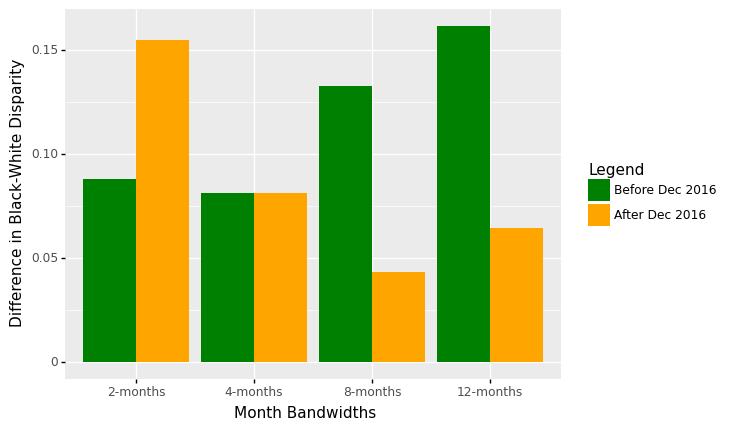

<ggplot: (287526154)>

In [27]:
#Create copy of data
ex_data = bwdata.copy()

#Filter to retail theft offenses 
ex_data = ex_data.loc[ex_data.simplified_offense_derived == "Retail Theft"]

#Create column to check if defendent was incarcerated 
ex_data["black_incarcerated"] = np.where((ex_data.is_black_derived == True) & (ex_data.COMMITMENT_TYPE == "Illinois Department of Corrections"), True, False)
ex_data["white_incarcerated"] = np.where((ex_data.is_white_derived == True) & (ex_data.COMMITMENT_TYPE == "Illinois Department of Corrections"), True, False)

#Create december object
dec_2016 = datetime.date(2016, 12, 1)

def find_disparities (search_in, bandwidth):
#Set up range
    upper_bound = dec_2016 + relativedelta(months=+bandwidth)
    lower_bound = dec_2016 + relativedelta(months=-bandwidth)
    range = pd.date_range(start=lower_bound, end=upper_bound) 
    
    #Filter to rows where data is in range 
    in_range = search_in[search_in["sentenceym_derived"].isin(range)]
    in_range = in_range[(in_range["sentenceym_derived"] < pd.to_datetime(dec_2016)) | (in_range["sentenceym_derived"] > pd.to_datetime(dec_2016))]

    #Create indicator to check if dates are after or before Dec 2016
    in_range["is_after"] = np.where(in_range["sentenceym_derived"] < pd.to_datetime(dec_2016), "beforedec2016", "afterdec2016") 

    #Group by indicator and race category 
    theft_range = in_range.groupby("is_after").agg({"CASE_ID" : "nunique",
                                                    "is_black_derived" : "sum",
                                                    "is_white_derived" : "sum",
                                                    "black_incarcerated" : "sum",
                                                    "white_incarcerated" : "sum"}).reset_index()

    return(theft_range)

#Interested month bandwidths 
monthBandwidths = [2, 4, 8, 12]

#Empty dataframe 
combined = pd.DataFrame()

#Iterate through list and add to empty dataframe 
for x in monthBandwidths: 
    one_bw = find_disparities(ex_data, x)
    ##all_matches = pd.concat(store_matches)

    
    combined = combined.append(one_bw) 

#Find inceration rate for both races and difference between them
combined["black_rate"] = combined["black_incarcerated"] / combined["is_black_derived"]
combined["white_rate"] = combined["white_incarcerated"] / combined["is_white_derived"]
combined = combined.drop(["CASE_ID", "is_black_derived", "is_white_derived", "black_incarcerated", "white_incarcerated"], axis=1)
combined["difference"] = combined["black_rate"] - combined["white_rate"]

#Add column storing bandwidth type
combined["months_bw"] = ["2-months", "2-months","4-months", "4-months", "8-months","8-months", "12-months", "12-months"]

#Reorder categories for barplot
combined["is_after"] = combined["is_after"].astype("category")
combined["is_after"] = combined["is_after"].cat.reorder_categories(["beforedec2016", "afterdec2016"])
combined["months_bw"] = combined["months_bw"].astype("category")
combined["months_bw"] = combined["months_bw"].cat.reorder_categories(["2-months", "4-months", "8-months", "12-months"])
combined

barplot = ggplot(combined, aes(x="months_bw", y="difference", group = "is_after", fill="is_after")) + geom_bar(stat="identity", position="dodge") + xlab("Month Bandwidths") + ylab("Difference in Black-White Disparity") 
barplot = barplot + scale_x_discrete(breaks=("2-months", "4-months", "8-months", "12-months")) + scale_fill_manual(name="Legend", labels=["Before Dec 2016", "After Dec 2016"], values=["green", "orange"])
barplot




### 2.3.3.1: Interpret the results (2 points)

Write a two-sentence interpretation of the results. What might this show about how people on both sides of the issue---those who argued that the retail theft policy change would narrow disparities; those who argued that the change may widen disparities--could support their claims? 

In [ ]:
#Based on the results, those who argue that the new policy narrowed disparities can say that in a longer bandwidth (8-month and 12-month),
#the drop in disparities is more evident while those who argue that the new policy may widen disparities can say that
#in a shorter bandwidth (2-month), the disparity increased immediately.In a shorter timespan, we can say cases might increase
#due to the lowered charge threshold and subsequently, more charges, and in a longer timespan, we can say that the 
#effect of the policy is more drastic where less charges are made compared to before.   

